In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')
import seaborn as sns
import sklearn
from scipy.stats import stats,ttest_ind

In [2]:
# Reading in the feature matrix data

# Import and store the feature matrix in the variable tsData
# Last column of the feature matrix should be the target column
path = '/Users/AV/Desktop/FeatureMatrixData/featureMatrixPy.txt'
tsData = pd.read_csv(path,header=None);

# print(tsData)

In [3]:
# Creating the target column - could maybe be done through user input?

[rows, cols] = tsData.shape

# bool = input('Is the first half of the data set the control set? y/n ')

# Create a 'target' column where rows 0-99 have the value 1 (indicating a seizure)
# and rows 100-199 have the value 0 (indicating no seizure)
zeros = np.zeros((100), dtype=int)
ones = np.ones((100), dtype=int)
targetCol = np.hstack((ones, zeros))
targetCol = np.reshape(targetCol,(200,1))

# print(targetCol)

In [4]:
# Need to z-score the feature matrix and save it back into the variable, tsData
# We are looking down each column and calculating the z-score for each feature
from scipy.stats import zscore
tsData_zscored = tsData.apply(zscore)

# Assign data to variables
X = tsData_zscored
y = np.ravel(targetCol)

In [5]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10)

# Import the support vector classifier and find the best fit using the training data
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

# Using the SVC derived from fitting to the training set, classify the test set
# and store this in a variable
y_pred = svclassifier.predict(X_test)

# Compare the predictions made by the SVC to the correct classifications
# Display the results using a confusion matrix and the classification accuracy
from sklearn.metrics import accuracy_score, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print('')
print('The classification accuracy of the SVM for a single random split is ' +
str(accuracy_score(y_test, y_pred) * 100) + '%')

# Calculate specificity (true negatives) and sensitivity (true positives)
confMat = confusion_matrix(y_test, y_pred)
specificity = (confMat[0,0] / (confMat[0,0] + confMat[1,0])) * 100
sensitivity = (confMat[1,1] / (confMat[1,1] + confMat[0,1])) * 100
print('The specificity is ' + str("%.1f" % specificity) + '% and the sensitivity is '
+ str("%.1f" % sensitivity) + '%')
print('')

[[ 7  1]
 [ 0 12]]

The classification accuracy of the SVM for a single random split is 95.0%
The specificity is 100.0% and the sensitivity is 92.3%



In [6]:
"NEED TO CALCULATE THE AVERAGE SPECIFICITY AND SENSITIVITY"
# Performing a 10-fold validation using cross_val_score
from sklearn.model_selection import cross_val_score
scores = cross_val_score(svclassifier, X, y, cv=10) * 100
scores = scores.astype(int)

# Print scores
print('10-fold CV scores as a percentage: ' + str(scores))
print('')

avgCVScore = np.mean(scores)
print('The average 10-fold CV score is ' + str("%.1f" % avgCVScore) + '%')
print('')

10-fold CV scores as a percentage: [100 100  95 100 100 100 100 100  95 100]

The average 10-fold CV score is 99.0%



In [7]:
# Compute the t-value (from a two-tail t-test) and the p-value
# Store these two values (t-value, then p-value) in each row, 22 in total for each feature

# Initialise the array and assign its shape
tpValArray = np.zeros([22, 2])
[rows, cols] = tpValArray.shape

"NEED TO GENERALISE FOR ANY CASE"
# Loop through the array and store the t and p values
for i in range(rows):

    # Calculate the t and p values by inputting the two halves of each of the 22 columns
    # of the normalised data into the ttest functions
    # Store the statistics in the variable, tpVal (which changes on each iteration of the outer loop)
    setE_FeatureCol = tsData.iloc[0:100,i]
    setA_FeatureCol = tsData.iloc[100:200,i]
    tpVal = stats.ttest_ind(setA_FeatureCol, setE_FeatureCol)

    for j in range(cols):

        # Store the values into each column
        tpValArray[i,j] = tpVal[j]

# Since it is a two-tailed t-test, need to multiply the p-values by two (second column)
tpValArray[:,1] = tpValArray[:,1] * 2

# Formatting the tpValArray
tpValDf = pd.DataFrame(data=tpValArray, columns=['t-value', 'p-value'])
tpValDf.index.name = 'Feature i'
print(tpValDf)
print('')

# Sort the data (including the indices) in descending order by MAGNITUDE
tpValDf_sorted = tpValDf.abs().sort_values(by='t-value',ascending=False)
print(tpValDf_sorted)
print('')

# Store the first five indices of the sorted dataframe - will need to use these
# indices to access the relevant feature columns in X, the feature matrix
indexVals = tpValDf_sorted.index.values
signifTVals = indexVals[:5]
print(signifTVals)
print('')

             t-value       p-value
Feature i                         
0          -1.646650  2.024324e-01
1          -4.640577  1.262330e-05
2          -8.430390  1.413439e-14
3           0.349755  1.453788e+00
4          -0.062478  1.900491e+00
5          -0.579031  1.126453e+00
6          -2.093077  7.523217e-02
7           3.147426  3.803229e-03
8           3.366957  1.826104e-03
9         -16.637060  3.679283e-39
10          2.182296  6.052926e-02
11          0.444272  1.314662e+00
12         10.982195  6.440116e-22
13         -5.027799  2.215562e-06
14        -10.876303  1.333349e-21
15          5.418917  3.461260e-07
16         10.997517  5.795681e-22
17         -3.572155  8.891152e-04
18         22.421473  6.111434e-56
19          6.873038  1.598130e-10
20         -5.333284  5.239965e-07
21         -2.376740  3.683915e-02

             t-value       p-value
Feature i                         
18         22.421473  6.111434e-56
9          16.637060  3.679283e-39
16         10.99751

          PC1       PC2  target
0   -0.466520  0.972985       1
1   -1.715950  0.268570       1
2   -3.689212  2.210228       1
3    0.466398  2.224022       1
4    2.273560  2.025920       1
5    1.693349  1.513487       1
6    0.359110 -2.120276       1
7    2.061841  5.180776       1
8    0.378024  1.979334       1
9   -5.406274  1.937100       1
10  -2.735661  2.122185       1
11   1.842068  3.662893       1
12   0.420461  3.752155       1
13   2.247172 -0.902285       1
14   4.330223 -0.620903       1
15   9.720630 -2.325618       1
16  -1.637008  0.316295       1
17   4.577674 -1.305677       1
18   2.134502  2.645816       1
19  -0.679428  3.272365       1
20   2.768670  1.188821       1
21  -0.813806  2.083404       1
22   0.499360  0.697161       1
23  -0.512965  2.415875       1
24   3.399703  0.543144       1
25   0.887098  3.788475       1
26  -2.954070  1.048640       1
27   1.845831  2.254107       1
28   6.486638 -1.685124       1
29  -2.365089  1.899525       1
..      

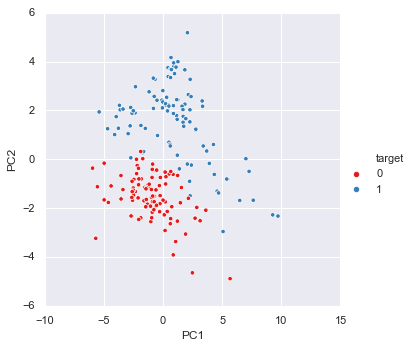

In [8]:
# PCA
from sklearn.preprocessing import StandardScaler

# Standardizing the features
x = StandardScaler().fit_transform(tsData)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents
             , columns=['PC1', 'PC2'])

targetCol_df = pd.DataFrame(data=targetCol, columns=['target'])

finalDf = pd.concat([principalDf, targetCol_df], axis = 1)

print(finalDf)

# Plotting the PCA scatterplot using Seaborn
sns.set()
ax = sns.relplot(x='PC1', y='PC2', data=finalDf, hue='target',palette='Set1')
plt.show()

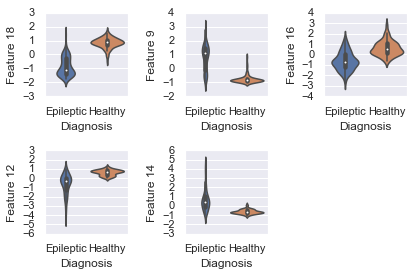

In [9]:
# Create an index for the subplot
n = 1;

fig = plt.figure()

for i in signifTVals:
    # Obtaining Seizure_Feature_i & Healthy_Feature_i
    # (all the rows) from the ith column of the feature matrix
    sf_i = X.iloc[0:100,i]
    hf_i = X.iloc[100:200,i]

    # Stacking columns side by side
    feat_i = np.column_stack((sf_i,hf_i))

    # Making the numpy array into a dataframe
    df_feat_i = pd.DataFrame(data=feat_i, columns=['Epileptic', 'Healthy'])
    # print(df_feat_i)

    # Violin plots
    ax = fig.add_subplot(2,3,n)
    ax = sns.violinplot(data=df_feat_i, order=["Epileptic", "Healthy"])
    plt.xlabel('Diagnosis')
    ylabel = 'Feature ' + str(i)
    plt.ylabel(ylabel)

    # Increment index
    n += 1;

plt.tight_layout()
plt.show()